In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

In [2]:
# Create dataset
N = 4096
B = 1024
unique_k_list = [1,0.5,0.25]
data = StepFunctionEventsDataset(N, unique_k_list)
loader = DataLoader(data, batch_size=B, shuffle=True, num_workers=4)

In [3]:
# Create NN model
num_freqs = 6
num_latent = 10
model = Autoencoder(40 * (2*num_freqs+1), num_latent, 2*num_freqs+1, 1, lam_TV = 1)
trainer = pl.Trainer(max_epochs=200, accelerator=device, devices=1, plugins=[DisabledSLURMEnvironment(auto_requeue=False)], log_every_n_steps=8)
history = trainer.fit(model, loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /nobackup/users/yankeson/ppae/lightning_logs/version_360967/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | ResnetFC           | 59.0 K
1 | decoder | ResnetFC           | 26.6 K
2 | code    | PositionalEncoding | 0     
-----------------------------------------------
85.5 K    Trainable params
0         Non-trainable params
85.5 K    Total params
0.342     Total estimated model params size (MB)
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/pyto

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [16]:
# Visualize training
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [4]:
# Test data, currently just the training data
test_loader = DataLoader(data, batch_size=N)
test_batch = next(iter(test_loader))
model.eval()
with torch.no_grad():
    model.encode(model.code(test_batch['event_list']).reshape(N,-1))
    z = model.latent.cpu().numpy()


In [18]:
##### t-SNE
from bhtsne import tsne
data_nd_tsne = tsne(z.astype(np.float64))


# ##### PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# embedding = pca.fit_transform(z)

# labels = test_batch['type'].numpy()
# unique_labels = np.unique(labels)
# colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

# plt.figure(figsize=(8, 6))
# for i, label in enumerate(unique_labels):
#     idx = labels == label
#     plt.scatter(embedding[idx, 0], embedding[idx, 1], color=colors[i], label=label, marker='o',s=3)

# plt.xlabel('PCA component 1')
# plt.ylabel('PCA component 2')
# plt.legend(loc='best')
# plt.title('PCA of latent representations')
# plt.show()

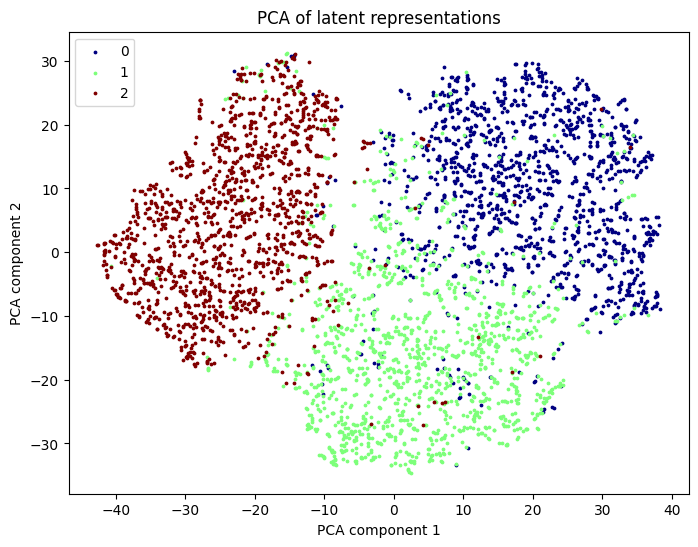

In [21]:
labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.scatter(data_nd_tsne[idx, 0], data_nd_tsne[idx, 1], color=colors[i], label=label, marker='o',s=3)

plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend(loc='best')
plt.title('PCA of latent representations')
plt.show()

[[ 3.3334374  -7.960883    0.56773573 ... -2.3908203  -3.505
  -3.0484684 ]
 [ 3.7600524  -6.862407   -0.23089665 ... -1.2331642  -2.084887
  -2.7364972 ]
 [ 2.9749079  -6.895184    0.43488353 ... -1.6647449  -3.1114373
  -1.9104037 ]
 ...
 [ 4.207533   -6.628626    0.63763946 ... -1.7316498  -2.306139
  -2.2766438 ]
 [ 3.4013972  -8.572982    0.47959343 ... -1.2231044  -2.8189507
  -2.828584  ]
 [ 3.9422116  -6.576615    0.81698436 ... -1.8059553  -2.803729
  -1.7099437 ]]


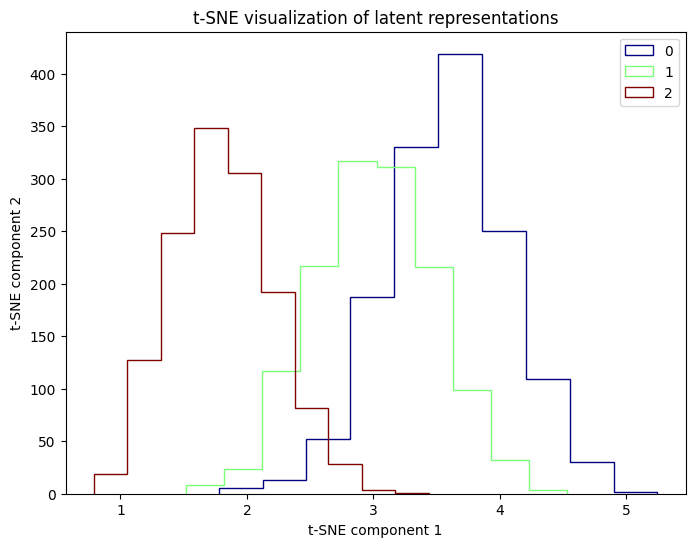

In [10]:
labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
print(z)
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.hist(z[idx, 4], color=colors[i], histtype='step', label=label)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(loc='best')
plt.title('t-SNE visualization of latent representations')
plt.show()

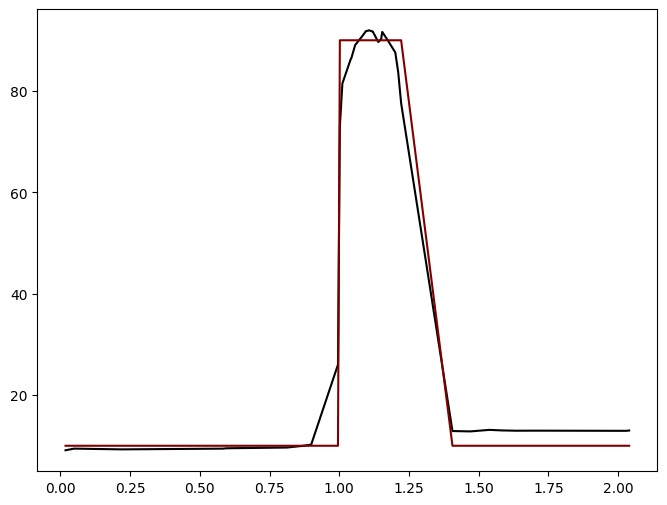

In [13]:
# Visualize the rate function that the NN has learned.
index = 1

with torch.no_grad():
    coded = model.code(test_batch['event_list'])
    rates = model.decode(coded)
    
# Calculate true rates
labels = test_batch['type'].numpy()
k_list = torch.tensor([1,0.5,0.25])[labels].unsqueeze(-1)
true_rates = 10 + 20 / k_list * (coded[:,:,0] >= 1) * (coded[:,:,0] <= (1+k_list))

plt.figure(figsize=(8,6))
plt.plot(coded[index,:,0], torch.exp(rates[index,:,0]),color='k')
plt.plot(coded[index,:,0], true_rates[index,:], color = colors[labels[index]])
